# Multiparametrisk MRI (c) - SNR, CNR

A. Lundervold og A.S. Lundervold, Versjon 06.01.2020 

I denne trinnvise utvikling av Python kode vil du lære å måle "kontrast-til-støy-forhold" (CNR) mellom hvert par av seks ulike vevstyper (luft/ben [air], grå substans [gm], hvit substans [wm], cerebrospinalvæske [csf], fett [fat] og muskel [mus]) i hvert av fire kanal-bilder (flash, dess, fisp og psif) fra et saggital-stilt multispektralt vevsskive-bilde av hodet (se figurer nedenfor). 

## Teori: SNR, CNR

Vi definerer **signalet** S$_A$ for et gitt vev $A$ til å være gjennomsnittet av signalintensitet i en region av piksler (kalt en maske) som dekker vevstypen $A$ (og bare denne - ellers har vi en "kontaminert" vevsmaske). 

Vi definerer **kontrast**  mellom to vev $A$ og $B$ til å være signal-forskjellen C$_{AB}$ = S$_A$ - S$_B$, der vi antar S$_A$ > S$_B$ slik at kontrast alltid er positiv (alternativt: C$_{AB}$ = |S$_A$ - S$_B$|). 

For et vev $A$, definerer vi **signal-til-støy-forhold**, betegnet SNR$_A$, til å være forholdet mellom signal($A$) og støy, i.e. SNR$_A$ =
S$_A$ / $\sigma_0$, der $\sigma_0$ er støy-nivået. 

For enkelthets skyld antar vi  **støyen** $\sigma_0$ å være den samme for alle vev og lik standardavviket til signalintensiteten i bakgrunnen (i.e. $\sigma_0$ = $\sigma_{air}$). 

Dette fører til følgende definisjon av **kontrast-til-støy-forhold**, CNR mellom to vev $A$ og $B$

> CNR$_{AB}$ = C$_{AB}$ / $\sigma_0$ = (S$_A$ - S$_B$) / $\sigma_0$ = SNR$_A$ – SNR$_B$


Se også [CNR i wikipedia](https://en.wikipedia.org/wiki/Contrast-to-noise_ratio), og evt. [On the Definition of Signal-To-Noise Ratio and Contrast-To-Noise Ratio for fMRI Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3819355)

Figuren nedenfor viser et fire-kanals multispektralt bilde (skive 60 fra et multispektral 3D opptak),  <br>
rapportert i  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326 <br>
og en manuelt tegnet trenings-maske med 6 vevstyper (farge-kodet i [R,G,B]) som følger: 

 - AIR (luft/ben) i Magenta [255,0,255]
 - GM  (grå substans) i Rød  [255,0,0] 
 - WM  (hvit substans) i Cyan [0,255,255]
 - CSF (cerebrospinalvæske) i Blå [0,0,255]
 - MUS (muskel) i Grønn [0,255,0] 
 - FAT (fett) i Gul [255,255,0]
 
**SJEKK UT:** *Multispektral MRI analyse startet med arbeidet til [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspirert av forskning ved NASA!*

**Figuren nedenfor viser manuell farge-kodet merking av pixler tilhørende seks ulike vevstyper ("klasser") og tilhørende multispektralt MRI opptak**<br>
Predefinerte vevstyper (klasser): luft/ben - 'air', grå substans - 'gm', hvit substans - 'wm', cerebrospinalvæske -'csf',  muskel - 'mus', fett -'fat'<br>
Kanaler/pulssekvenser (egenskapsvektorer): FLASH, DESS, FISP, PSIF

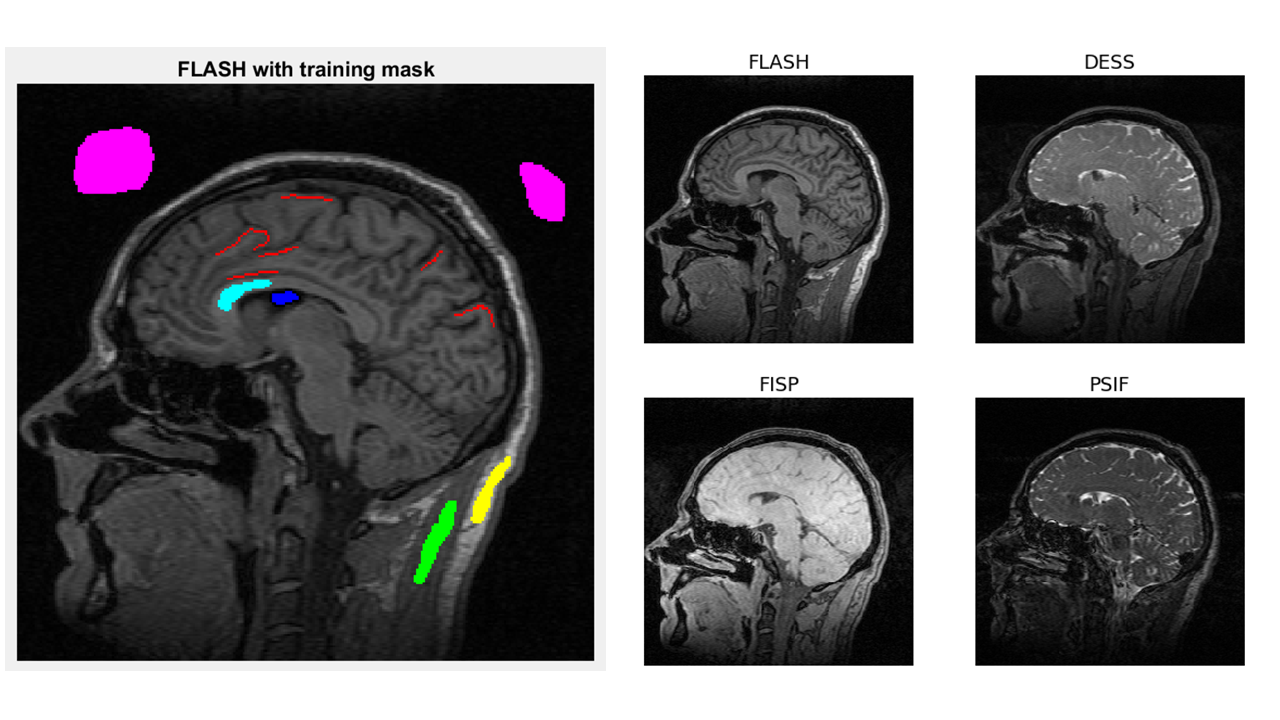

In [4]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

 > **Din tur!** 
 >
 > - Hvilken kanal (pulssekvens) synes du gjennomgående har best CNR? (zoom inn på kanalbildene)

**Importer bibliotekene som skal brukes**

In [5]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import IPython

home = os.path.expanduser('~')  # home is to make path to local home directory
print('home: %s' % home)

print('nibabel:',nib.__version__)

home: /Users/arvid
nibabel: 3.0.0


**Definer kataloger, kanal-navn ([MRI pulssekvenser](https://radiopaedia.org/articles/mri-pulse-sequences-1)) og klasse-navn ([vevstyper](https://en.wikipedia.org/wiki/Tissue_(biology))) som inngår**

[MRI pulssekvens forkortelser](https://radiopaedia.org/articles/mri-pulse-sequence-abbreviations):

 - FLASH - Fast Low Angle Shot [[ref](https://en.wikipedia.org/wiki/Fast_low_angle_shot_magnetic_resonance_imaging)]
 - DESS - Double Echo Steady State [[ref](http://mriquestions.com/dess.html)]
 - FISP - Fast Imaging with Steady-state free Precession [[ref](http://mriquestions.com/psif-vs-fisp.html)]
 - PSIF - revers FISP

In [6]:
mydata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

## Les inn multispektralt bilde

In [7]:
fn_multispectral = '../data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)

**Vis karakteristika ved det multispektrale NIFTI-bildet**

In [8]:
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_fdata()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
dat = np.uint16(data.squeeze())
print('shape of 2D+spectral dat = ',dat.shape)
print('dtype of 2D+spectral dat = ',dat.dtype)

shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral dat =  (256, 256, 4)
dtype of 2D+spectral dat =  uint16


**Vis bilde-data i de enkelte kanalene i det multispektrale bildet**

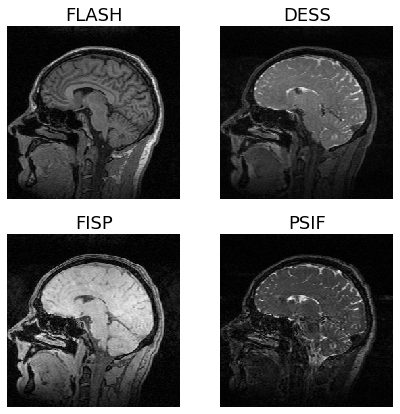

In [9]:
fig = plt.figure('Showing the multispectral image', figsize = [7, 7])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title(chn_names[0], fontsize=18)
plt.imshow(dat[:, :, 0].T, cmap='gray', origin='lower')  # .T for transpose to correct orientation
plt.subplot(2, 2, 2).set_axis_off(), plt.title(chn_names[1], fontsize=18)
plt.imshow(dat[:, :, 1].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title(chn_names[2], fontsize=18)
plt.imshow(dat[:, :, 2].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title(chn_names[3], fontsize=18)
plt.imshow(dat[:, :, 3].T, cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/ELMED219/results/flash_dess_fisp_psif_channel_images.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Støy i (MR) bildet - analysere støy, legge til kjent støy

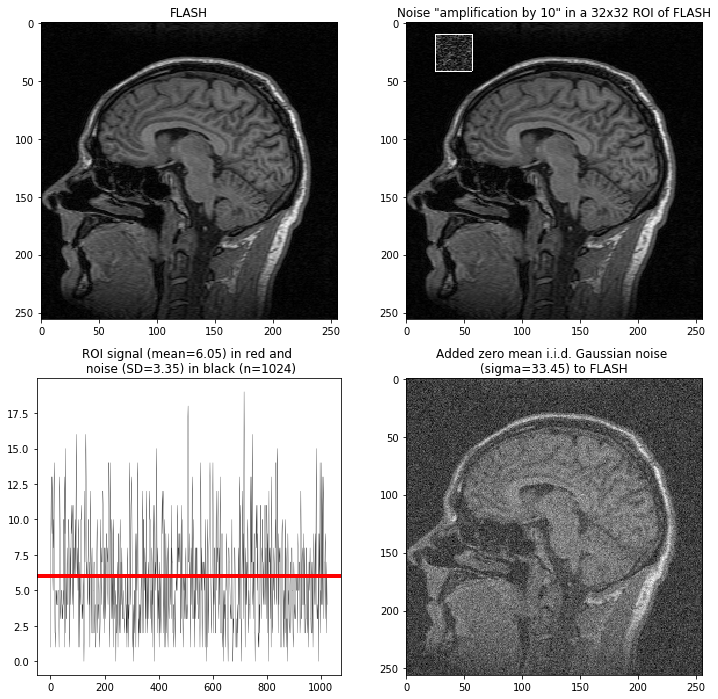

In [11]:
# Define a quadratic ROI
r = 10 # row
c = 25 # col
d = 32 # side-length
a = 10 # amplification factor

# Read the previously saved multispactral nifiti image
img = nib.load(fn_multispectral)
data = img.get_fdata()
flash_data = np.flip(data[:, :, :, 0].squeeze().T, 0)
mx = flash_data.max()

flash_data_upper_left = flash_data.copy()
flash_data_upper_left[r:r+d, c:c+d] = a*flash_data[r:r+d, c:c+d]

roi_bck = flash_data[r:r+d, c:c+d].flatten()
roi_mean = roi_bck.mean()
roi_std = roi_bck.std()

flash_data_upper_left[r, c:c+d] = mx
flash_data_upper_left[r+d, c:c+d] = mx
flash_data_upper_left[r:r+d, c] = mx
flash_data_upper_left[r:r+d, c+d] = mx

# Define characteristics of noisy image
mean = 0.0          # zero mean
std = a*roi_std     # noise standard deviation amplification
noisy_flash = flash_data + np.random.normal(mean, std, flash_data.shape)


fig = plt.figure(figsize = [12, 12])
plt.subplot(2,2,1)
plt.imshow(flash_data, cmap='gray')
plt.title('FLASH')
plt.subplot(2,2,2)
plt.imshow(flash_data_upper_left, cmap='gray' )
plt.title('Noise "amplification by %d" in a %dx%d ROI of FLASH' % (a, d, d))
plt.subplot(2,2,3)
plt.plot(roi_bck, linewidth=0.25, color='k')
plt.axhline(y=roi_mean, linewidth=4, color='r')
plt.title('ROI signal (mean=%.2f) in red and \n noise (SD=%.2f) in black (n=%d)' % (roi_mean, roi_std, d*d))
plt.subplot(2,2,4)
plt.imshow(noisy_flash, cmap='gray' )
plt.title('Added zero mean i.i.d. Gaussian noise \n(sigma=%.2f) to FLASH' % (std))

plt.show()

#fig.savefig('%s/prj/ELMED219/results/flash_and_additive_zero_mean_iid_gaussian_noise.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Les inn trenings-maske og ROI-maske

In [12]:
fn_train = '%s/flash_060_training_mask_6cla.png' % (mydata)
fn_roi = '%s/flash_060_brain_mask.png' % (mydata)

**Les .png filer ved bruk av Matplotlib**
`?plt.imread`

In [13]:
train_msk = plt.imread(fn_train)
roi_msk = plt.imread(fn_roi)

print('train_msk.dtype:', train_msk.dtype)
print('roi_msk.dtype:', roi_msk.dtype)
print('train_msk.shape:', train_msk.shape)
print('roi_msk.shape:', roi_msk.shape)
print('train_msk.min , max:', train_msk.min(), ',', train_msk.max())

train_msk.dtype: float32
roi_msk.dtype: float32
train_msk.shape: (256, 256, 3)
roi_msk.shape: (256, 256, 3)
train_msk.min , max: 0.0 , 1.0


**Skalér maske-bildene til uint8 RGB bilder, dvs. R,G,B $\in$ {0,...,255}**

In [14]:
train_msk = np.uint8(train_msk*255.0)
roi_msk = np.uint8(roi_msk*255.0)
print('train_msk.min:', train_msk.min(), ',', 'train_msk.max:', train_msk.max())

train_msk.min: 0 , train_msk.max: 255


**Vis trenings-maske og ROI-maske (maske som dekker interesseområdet)**<br>

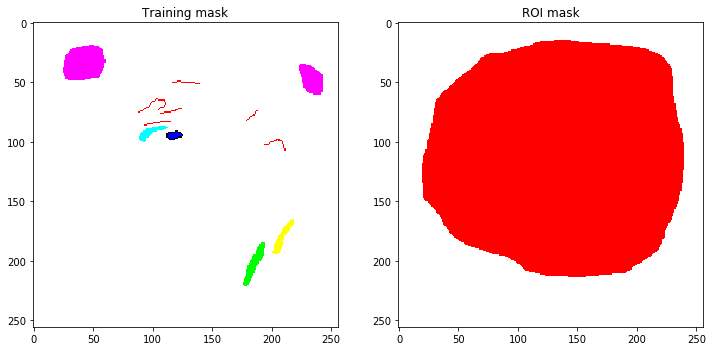

In [15]:
%matplotlib inline
fig = plt.figure('Showing the training mask and the ROI mask', figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(train_msk)
plt.title('Training mask')
plt.subplot(1,2,2)
plt.imshow(roi_msk)
plt.title('ROI mask')
plt.show()

**Skriver ut RGB-verdien i midten av ROI-masken (forventes å være rød)**

In [16]:
row = np.uint8(np.ceil(roi_msk.shape[0]/2))  # row of target pixel location
col = np.uint8(np.ceil(roi_msk.shape[1]/2)) # column
v = roi_msk[row, col,:] # RGB-value at this pixel-location 
print('roi_msk[%d, %d,:] =' % (row, col)); print(v)

roi_msk[128, 128,:] =
[255   0   0]


**Lager en ny binær uint8 matrise ("targ") der vi setter 0 (sort) til alle pixel-lokasjonene utenfor treningsmasken og 1 (hvit) i alle lokasjoner som representerer en vevstype det er trent på (target).**<br>
I den farge-kodete treningsmasken er hvit (=[255,255,255]) brukt til å representere bakgrunn.<br>
Vi bruker her `np.all` som kan forklares nærmere ved å skrive `?np.all` i en celle.

In [17]:
# ?np.all

In [18]:
targ = 1 - np.all(train_msk == [255,255,255], axis=2).astype(np.uint8)
targ_roi = 1 - np.all(roi_msk == [255,255,255], axis=2).astype(np.uint8)
print('train_msk.shape', train_msk.shape)
print('targ.shape', targ.shape)

train_msk.shape (256, 256, 3)
targ.shape (256, 256)


**Viser farge-kodet treningsmaske og tilhørende binære masker for hhv trenings-pixler og ROI-pixler**

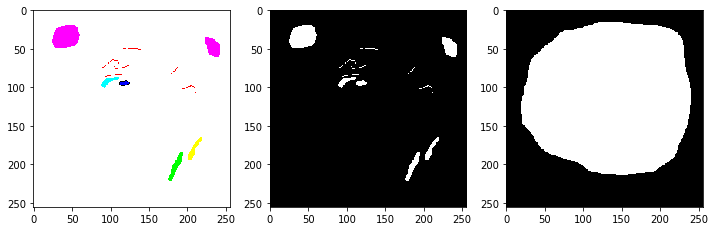

In [19]:
%matplotlib inline
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,3,1)
plt.imshow(train_msk)
plt.subplot(1,3,2)
plt.imshow(targ,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(targ_roi, cmap='gray')
plt.show()

**Beregn antall forekomster av hver unik farge (dvs. antall pixler i hver klasse) i treningsmasken og i synkende orden**

In [20]:
from collections import Counter
Counter([tuple(colors) for i in train_msk for colors in i]).most_common()

[((255, 255, 255), 63519),
 ((255, 0, 255), 1250),
 ((0, 255, 0), 250),
 ((255, 255, 0), 170),
 ((255, 0, 0), 136),
 ((0, 255, 255), 129),
 ((0, 0, 255), 51),
 ((0, 0, 0), 31)]

**Vi kan også lage og vise en grå-skala treningsmaske avledet fra den farge-kodete treningsmasken ved bruk av OpenCV og transformasjonen COLOR_RGB2GRAY**

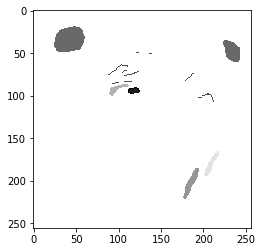

In [21]:
%matplotlib inline
train_msk_grey = cv2.cvtColor(train_msk, cv2.COLOR_RGB2GRAY)
plt.imshow(train_msk_grey, cmap='gray')
plt.show()

**Beregn antall forekomster av hver unik gråtone (dvs. antall pixler i hver klasse) i grå-skala treningsmaske i synkende rekkefølge**

In [22]:
a = train_msk_grey.flatten()
unique, counts = np.unique(a, return_counts=True)
d = dict(zip(unique, counts))
sorted_by_counts = sorted(d.items(), key=lambda v: v[1], reverse=True)  # by second element
sorted_by_counts

[(255, 63519),
 (105, 1250),
 (150, 250),
 (226, 170),
 (76, 136),
 (179, 129),
 (29, 51),
 (0, 31)]

**MERK:** I farge-kodingen av treningsmasken (og i gråtone-masken) vil hhv. [0,0,0] og 0 vises som sort (tilsammen 31 pixler) og motsvarer ingen av de predefinerte klassene. Dette er **en feil i den manuelle merking** av vevstyper og disse verdier bør tilordnes bakgrunn, hhv. [255,255,255] og 0.

> **Din tur!**
>
> - Finn frem til disse feil-kodete sorte pixler, vis disse og lag en korrigert trenings-maske der disse inngår som bakgrunn <br>(utført implisitt senere i notebooken)

In [23]:
# Your code:

## Superponér farge-kodet maske på grå-skala bilde

**Superponér farge-kodet treningsmaske på FLASH kanal-bilde**<br>

Her ved bruk av "brute force" pixel-gjennomløping  ...

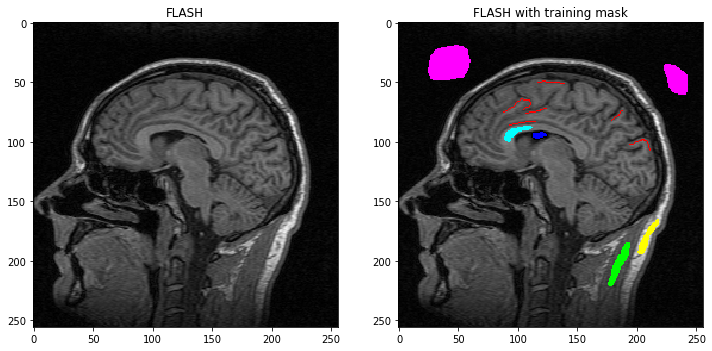

In [24]:
%matplotlib inline
# Scale the intensity in FLASH to a maximum of mymax to keep data within a uint8 (0-255) range
mymax = 200
flash_channel = dat[:, :, 0].squeeze()   # dat[:,:,0] is the FLASH channel
flash_channel = np.flip(flash_channel.T, 0)  # This numpy matrix manipulation step is explained later
flash_max = mymax * (flash_channel/flash_channel.max())
nrow, ncol = flash_max.shape
r = min(flash_channel.max(), 255) / mymax  # Scaling for the superimposed gray-scale pixels

# Define the RGB / grey-level composite (overlay) uint8 image
# by returning a new array of given shape and type, filled with zeros
flash_train_rgb = np.zeros(shape=(nrow,ncol,3), dtype=np.uint8)

# Loop over all pixels (this is brute force)
for i in range(nrow):
    for j in range(ncol):
        # Check if pixel coordinate is member of a tissue mask (white)
        if (targ[i,j] == 1):
           # Keep the mask RGB color (using RGB values in {0,,,.255}) at this location         
            for k in range(3):
                flash_train_rgb[i,j,k] = train_msk[i,j,k]
        else:
            # Make a gray-level pixel according to the signal intensity in rescaled FLASH
            for k in range(3):
                flash_train_rgb[i,j,k] = np.uint8(np.ceil(flash_max[i,j]*r))
                
fig = plt.figure(figsize = [12, 7])
plt.subplot(1,2,1)
plt.imshow(flash_max, cmap='gray'), plt.title('FLASH')
plt.subplot(1,2,2)
plt.imshow(flash_train_rgb), plt.title('FLASH with training mask')
plt.show()

#fig.savefig('%s/prj/ELMED219/results/flash_with_training_mask_6_classes.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

##  Finn alle pixler der RGB-tuplene motsvarer en klasse

**Farge-koding av vevstyper brukt under manuell merking av pixler(i FLASH-kanalen)** <br>
Det finnes flere programmer som er egnet til dette, idag ville vi anbefale __[ITK-SNAP](http://www.itksnap.org)__.

In [25]:
AIR = [255,0,255] # Magenta 
GM  = [255,0,0]   # Red 
WM  = [0,255,255] # Cyan 
CSF = [0,0,255]   # Blue 
MUS = [0,255,0]   # Green 
FAT = [255,255,0] # Yellow 

ERR = [0,0,0] # Black
BCK = [255,255,255] # White (background)

Én mulig frmegangsmåte: finn alle pixler der treningsmaske-verdi er klasse-verdi (RGB-farge) for hver av klassene

In [26]:
air = np.all(train_msk == AIR, axis=2).astype(np.int)
n_air = np.count_nonzero(air)
print('n_air =', n_air)

gm = np.all(train_msk == GM, axis=2).astype(np.int)
n_gm = np.count_nonzero(gm)
print('n_gm =', n_gm)

wm = np.all(train_msk == WM, axis=2).astype(np.int)
n_wm = np.count_nonzero(wm)
print('n_wm =', n_wm)

csf = np.all(train_msk == CSF, axis=2).astype(np.int)
n_csf = np.count_nonzero(csf)
print('n_csf =', n_csf)

mus = np.all(train_msk == MUS, axis=2).astype(np.int)
n_mus = np.count_nonzero(mus)
print('n_mus =', n_mus)

fat = np.all(train_msk == FAT, axis=2).astype(np.int)
n_fat = np.count_nonzero(fat)
print('n_fat =', n_fat)

err = np.all(train_msk == ERR, axis=2).astype(np.int)
n_err = np.count_nonzero(err)
print('\nn_err =', n_err)

bck = np.all(train_msk == BCK, axis=2).astype(np.int)
n_bck = np.count_nonzero(bck)
print('n_bck =', n_bck)

n_air = 1250
n_gm = 136
n_wm = 129
n_csf = 51
n_mus = 250
n_fat = 170

n_err = 31
n_bck = 63519


Eller mer kompakt - en (nøkkel, verdi) **dictionary**

In [27]:
col_code = {
    'AIR': [255,0,255],  # Magenta 
    'GM':  [255,0,0],    # Red 
    'WM':  [0,255,255],  # Cyan 
    'CSF': [0,0,255],    # Blue 
    'MUS': [0,255,0],    # Green 
    'FAT': [255,255,0],  # Yellow 
    'ERR': [0,0,0],      # Black
    'BCK': [255,255,255] # White (background)
}

Eksempel på konstrukjson av kommandoer av programsetninger med sine spesifikke parametere, og deretter eksekvering av disse med __[exec](https://www.geeksforgeeks.org/exec-in-python)__

In [28]:
# Make separate masks for each class

for key in col_code.keys():
    keyl = key.lower()
    cmd1 = '%s = np.int16(np.all(train_msk == %s, axis=2))' % (keyl, key); exec(cmd1)
    cmd2 = 'n_%s = np.count_nonzero(%s)' % (keyl, keyl); exec(cmd2)
    cmd3 = 'print("n_%s =", n_%s)' % (keyl, keyl); exec(cmd3)

n_air = 1250
n_gm = 136
n_wm = 129
n_csf = 51
n_mus = 250
n_fat = 170
n_err = 31
n_bck = 63519


Et alternativ er bruk av Numpy's __[where](https://stackoverflow.com/questions/34667282/numpy-where-detailed-step-by-step-explanation-examples)__ til å lage
**en kompositt grå-tone treningsmaske i henhold til klasse-numereringen**<br>
 AIR=1, GM=2, WM=3, CSF=4, MUS=5, FAT=6

In [29]:
# Using np.where() to find pixel locations for each class of the 6 valid tissue types
col_code_sub = {a: col_code[a] for a in ['AIR','GM','WM', 'CSF', 'MUS', 'FAT'] if a in col_code}
cc = list(col_code_sub.keys())
train_msk_1_6 = np.zeros(train_msk[:,:,0].shape, dtype=np.uint8)  # Initialize with background zero
for n, val in enumerate(col_code_sub.values()):
    m = cc[n].lower()
    mm = np.where((train_msk[:,:,0] == val[0]) & (train_msk[:,:,1] == val[1]) & (train_msk[:,:,2] == val[2]))
    train_msk_1_6[mm[0],mm[1]] = (n+1)  # # mm[0]: rows, mm[1]: cols
    print('cla_%d (%s) n=%d %d' % (n+1, m , len(mm[0]), np.count_nonzero(train_msk_1_6)))

cla_1 (air) n=1250 1250
cla_2 (gm) n=136 1386
cla_3 (wm) n=129 1515
cla_4 (csf) n=51 1566
cla_5 (mus) n=250 1816
cla_6 (fat) n=170 1986


Total number of training pixels: 1986


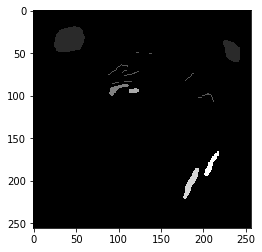

In [30]:
%matplotlib inline
#train_msk_1_6 = 1*air + 2*gm + 3*wm + 4*csf + 5*mus + 6*fat
plt.imshow(train_msk_1_6, cmap='gray')
print('Total number of training pixels: %d' % np.count_nonzero(train_msk_1_6))
plt.show()

**Sjekker klassefordelingen - som her er ubalansert (se f.eks. [Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset) og [`imbalanced-learn`](https://github.com/scikit-learn-contrib/imbalanced-learn/blob/master/README.rst))**

In [31]:
a = train_msk_1_6.flatten()
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 63550, 1: 1250, 2: 136, 3: 129, 4: 51, 5: 250, 6: 170}

**Lagre `training_mask_1_6` som int16 NIFTI bilde og bruker header-informasjon (affine) fra det multispekrale bildet**

In [33]:
fn_tmsk = '../data/mri/training_mask_1_6.nii.gz'
# We have to flip and transpose to align the mask to the multispectral image
training_mask_1_6 = np.flip(train_msk_1_6, 0).T 
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the mult
nrow = training_mask_1_6.shape[0]
ncol = training_mask_1_6.shape[1]
training_mask_1_6 = np.reshape(training_mask_1_6, (nrow, ncol, 1, 1))
tmsk = nib.Nifti1Image(np.int16(training_mask_1_6), img.affine )
nib.save(tmsk, fn_tmsk)

**Sjekk resultater!** (e.g. ved bruk av FreeSurfer's freeview)

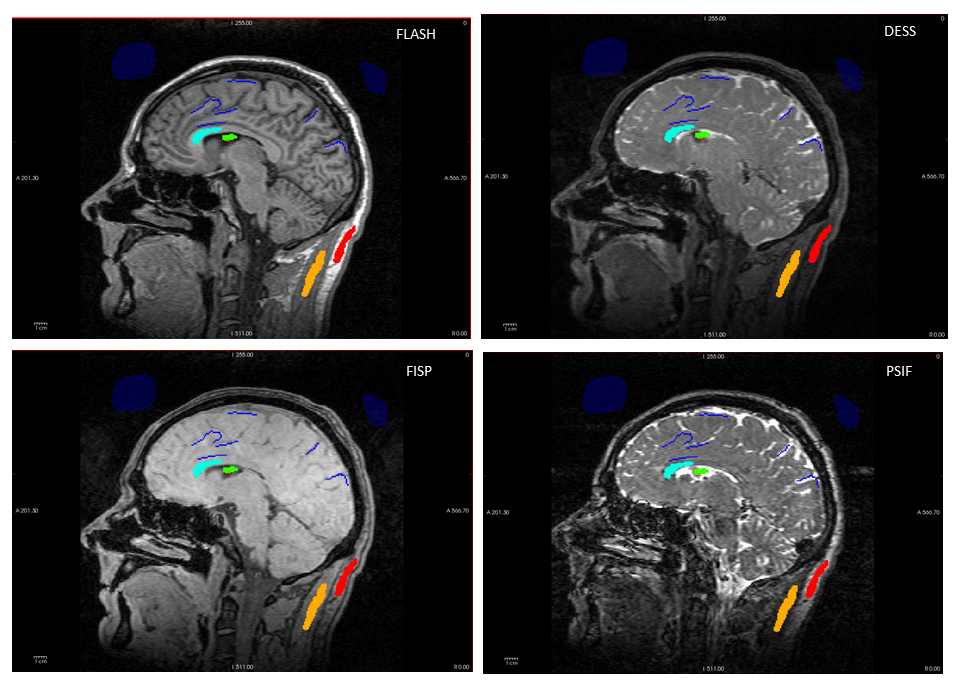

In [34]:
from IPython.display import Image
Image(filename='./assets/tmsk_on_channels_freeview_pptx.png', width=700)

eller bruk av nilearn's plotting

/Users/arvid/anaconda3/envs/elmed219/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  **kwargs)
/Users/arvid/anaconda3/envs/elmed219/lib/python3.7/site-packages/nilearn/plotting/displays.py:75: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  self.ax.axis(self.get_object_bounds())


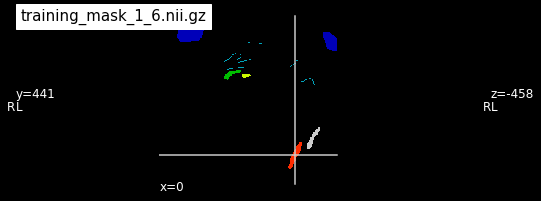

In [35]:
%matplotlib inline
plotting.plot_epi(fn_tmsk, title='training_mask_1_6.nii.gz')
plt.show()

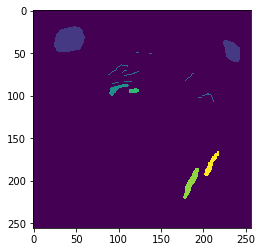

In [36]:

#plotting.plot_anat(img1_ap, title="multispectral chn1")
plt.imshow(train_msk_1_6)
plt.show()

**Lagre `brain_roi_mask` som int16 NIFTI bilde og bruker header-informasjon (affine) fra det multispekrale bildet**

In [37]:
fn_roi = '../testdata/brain_roi_mask.nii.gz'
#roi = np.all(roi_msk == [255,0,0], axis=1).astype(np.int)
#n_roi = np.count_nonzero(roi)
#print('n_roi =', n_roi)
# We have to flip and transpose to align the mask to the multispectral image
trag_roi = np.flip(targ_roi, 0).T 
# and make a 4-dim matrix with z-dim and spectral-dim both =1 to match the mult
nrow = targ_roi.shape[0]
ncol = targ_roi.shape[1]
targ_roi = np.reshape(trag_roi, (nrow, ncol, 1, 1))
rmsk = nib.Nifti1Image(np.int16(targ_roi), img.affine )
nib.save(rmsk, fn_roi)

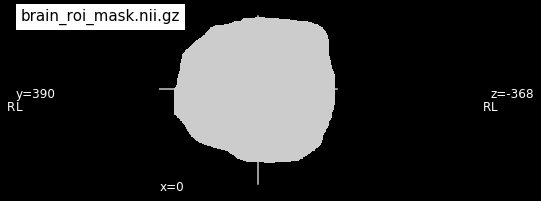

In [38]:
%matplotlib inline
plotting.plot_epi(fn_roi, title='brain_roi_mask.nii.gz')
plt.show()

**Viser trenings-pixlene i hver av de seks klasser som separate binære masker**

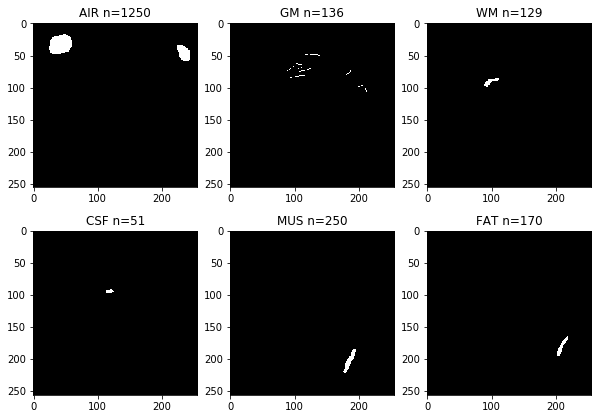

In [39]:
%matplotlib inline
fig = plt.figure('Showing the training masks', figsize = [10, 7])
plt.tight_layout
fonts = 12
plt.subplot(2,3,1), plt.title('AIR n=%d' % (n_air), fontsize=fonts)
plt.imshow(air, cmap='gray')
plt.subplot(2,3,2), plt.title('GM n=%d' % (n_gm), fontsize=fonts)
plt.imshow(gm, cmap='gray')
plt.subplot(2,3,3), plt.title('WM n=%d' % (n_wm), fontsize=fonts)
plt.imshow(wm, cmap='gray')
plt.subplot(2,3,4), plt.title('CSF n=%d' % (n_csf), fontsize=fonts)
plt.imshow(csf, cmap='gray')
plt.subplot(2,3,5), plt.title('MUS n=%d' % (n_mus), fontsize=fonts)
plt.imshow(mus, cmap='gray')
plt.subplot(2,3,6), plt.title('FAT n=%d' % (n_fat), fontsize=fonts)
plt.imshow(fat, cmap='gray')
plt.show()

## Finn vevstype- og sekvens-spesifikke MRI signal-intensiteter 

In [40]:
# Get data for each 2D channel image
p = len(chn_names)
flash_chn_dat = dat[:, :, 0].squeeze()
dess_chn_dat = dat[:, :, 1].squeeze()
fisp_chn_dat = dat[:, :, 2].squeeze()
psif_chn_dat = dat[:, :, 3].squeeze()

**OBS! Sjekk dine data (riktig bilde-orientering og overenstemmelse mellom treningsmaske og pixel-verdier!)**

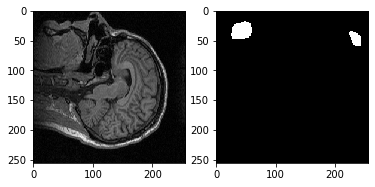

In [41]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(flash_chn_dat, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(air, cmap='gray')
plt.show()

**Vi må transponere kanal-bildet og flippe bildematrisen vertikalt**

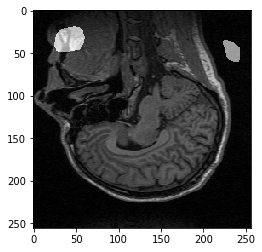

In [42]:
%matplotlib inline
plt.imshow(flash_chn_dat.T + 255*air, cmap='gray')
plt.show()

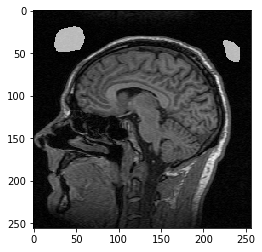

In [43]:
%matplotlib inline
plt.imshow(np.flip(flash_chn_dat.T, 0) + 255*air, cmap='gray')
plt.show()

In [44]:
flash_chn = np.flip(flash_chn_dat.T, 0)
dess_chn = np.flip(dess_chn_dat.T, 0)
fisp_chn = np.flip(fisp_chn_dat.T, 0)
psif_chn = np.flip(psif_chn_dat.T, 0)

**Konstruerer en funksjon som definerer en klasse-spesifikk p-dimensjonal egenskaps-matrise (data-matrise) <br> for en gitt klasse k $\in$ {air, gm, wm, csf, mus, fat}** 

In [45]:
def make_feature_matrix(k):
    '''
    Ex.
    A = make_feature_matrix(air)
    A.shape
    '''
    M = np.column_stack(
        (flash_chn[k == 1], 
         dess_chn[k == 1],
         fisp_chn[k == 1],
         psif_chn[k == 1]))
    return M

A = make_feature_matrix(air)
print('Noise in FLASH: %.2f (n=%d)' % (A[:,0].std(), A.shape[0]))
print('Noise in DESS : %.2f (n=%d)' % (A[:,1].std(), A.shape[0]))
print('Noise in FSIP : %.2f (n=%d)' % (A[:,2].std(), A.shape[0]))
print('Noise in PSIF : %.2f (n=%d)' % (A[:,3].std(), A.shape[0]))

Noise in FLASH: 3.47 (n=1250)
Noise in DESS : 4.88 (n=1250)
Noise in FSIP : 4.47 (n=1250)
Noise in PSIF : 3.44 (n=1250)


**Denne funksjonen brukes for å lage klasse-spesifikke Pandas data frames der egenakapene er <br> MRI signal-intensiteter (SI) i hver av kanalene i det multispektrale bildet** 

In [46]:
dfAIR = pd.DataFrame(make_feature_matrix(air), columns = chn_names)
dfAIR.insert(p, 'Class', 'AIR')
dfAIR.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [47]:
dfGM = pd.DataFrame(make_feature_matrix(gm),  columns = chn_names)
dfGM.insert(p, 'Class', 'GM')

In [48]:
dfWM = pd.DataFrame(make_feature_matrix(wm),  columns = chn_names)
dfWM.insert(p, 'Class', 'WM')

In [49]:
dfCSF = pd.DataFrame(make_feature_matrix(csf),  columns = chn_names)
dfCSF.insert(p, 'Class', 'CSF')

In [50]:
dfMUS = pd.DataFrame(make_feature_matrix(mus),  columns = chn_names)
dfMUS.insert(p, 'Class', 'MUS')

In [51]:
dfFAT = pd.DataFrame(make_feature_matrix(fat),  columns = chn_names)
dfFAT.insert(p, 'Class', 'FAT')
dfFAT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
167,229,34,112,135,FAT
168,235,32,117,159,FAT
169,251,31,125,172,FAT


**Konkatener de vevs-spesifikke data frames til et samlet treningsdata-sett (dfT), og lagre dette som en csv-fil i data-katalogen**

In [52]:
frames = [dfAIR, dfGM, dfWM, dfCSF, dfMUS, dfFAT]
dfT = pd.concat(frames, ignore_index=True)
dfT.to_csv('../testdata/multispectral_mri_training_data.csv', index=False)
dfT.head(3)

,FLASH,DESS,FISP,PSIF,Class
0,5,6,2,2,AIR
1,5,6,4,10,AIR
2,2,5,2,9,AIR


In [53]:
dfT.tail(3)

,FLASH,DESS,FISP,PSIF,Class
1983,229,34,112,135,FAT
1984,235,32,117,159,FAT
1985,251,31,125,172,FAT


## Eksplorativ Data Analyse (EDA) 
**Deskriptiv statistikk & grafikk**

In [54]:
# Make a list of the different class-labels in the training dataset
dfT['Class'].unique().tolist()

['AIR', 'GM', 'WM', 'CSF', 'MUS', 'FAT']

In [55]:
# Class-specific statistics accross the different features (channels)
dfT.groupby('Class').describe(percentiles = [0.5]).round(2).T

Class            AIR     CSF     FAT      GM     MUS      WM
FLASH count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.05   29.20  264.44  112.73  101.34  162.72
      std       3.47    6.67   40.78   11.18    8.81    6.87
      min       0.00   13.00  140.00   91.00   79.00  132.00
      50%       6.00   30.00  271.00  112.00  103.00  163.00
      max      19.00   46.00  338.00  152.00  123.00  178.00
DESS  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.92  129.29   45.18  127.43   50.77  117.88
      std       4.88   70.86    9.18   19.70    7.18    6.72
      min       0.00   42.00   24.00  100.00   28.00  101.00
      50%       6.00  110.00   45.00  124.50   51.00  118.00
      max      26.00  258.00   71.00  217.00   70.00  137.00
FISP  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.55   71.04  133.69  171.60  103.37  187.75
      std       4.47   12.17   25.82   16.72   21.55    8.11
      min       0.00   50.00   72.00  127.00   34.00  174.00
      50%       5.00   70.00  135.00  172.00  102.00  187.00
      max      26.00   99.00  185.00  221.00  144.00  209.00
PSIF  count  1250.00   51.00  170.00  136.00  250.00  129.00
      mean      6.00  285.41  152.31  154.75   45.33  112.36
      std       3.45  104.92   28.73   68.43   12.10   18.02
      min       0.00  104.00   68.00  103.00   19.00   66.00
      50%       6.00  324.00  154.00  126.00   45.00  113.00
      max      19.00  418.00  214.00  439.00   78.00  168.00

**Klasse-vis boxplot for hver egenskap (kanal)**

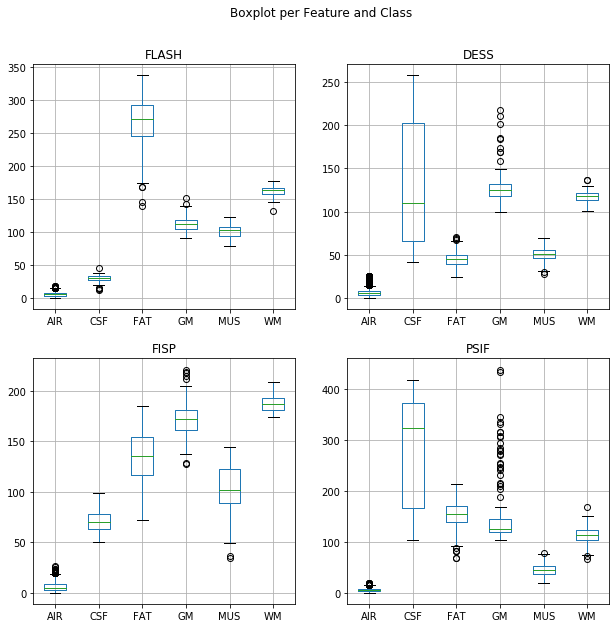

In [51]:
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    dfT.boxplot(column=[ch], by='Class', ax=ax[k])
    ax[k].set_title(ch.upper())
    ax[k].set(xlabel="")
plt.suptitle("Boxplot per Feature and Class")    
plt.show()

**Seaborn pairplot  - klasse-vis mellom alle par av kanaler**

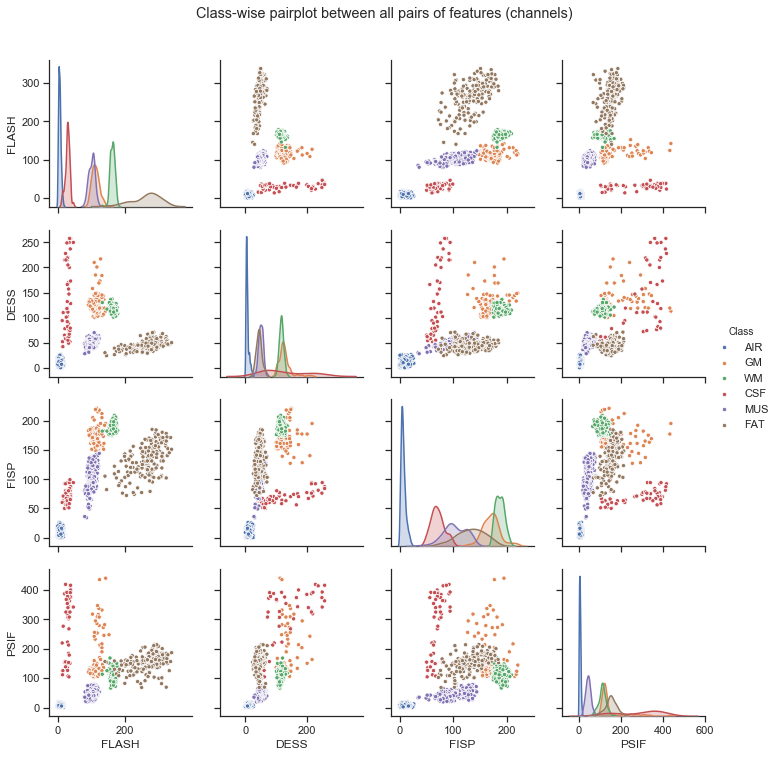

In [56]:
%matplotlib inline
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(dfT, hue="Class", vars = chn_names, plot_kws = {"size":10})
g.fig.suptitle("Class-wise pairplot between all pairs of features (channels)", y=1.05) 
plt.show()

#g.savefig('%s/prj/ELMED219/results/class_wise_pairplot_between_all_pairs_of_features_(channels).png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

**Lager figur med vevs-spesifikke SI-fordelinger (sannsynlighets-tettheter) for hver av kanalene**

In [57]:
# Find global SI min and max for each channel across all tissue types for same x-scaling
mn1 = dfT['FLASH'].min(); mx1 = dfT['FLASH'].max() 
mn2 = dfT['DESS'].min(); mx2 = dfT['DESS'].max() 
mn3 = dfT['FISP'].min(); mx3 = dfT['FISP'].max() 
mn4 = dfT['PSIF'].min(); mx4 = dfT['PSIF'].max() 

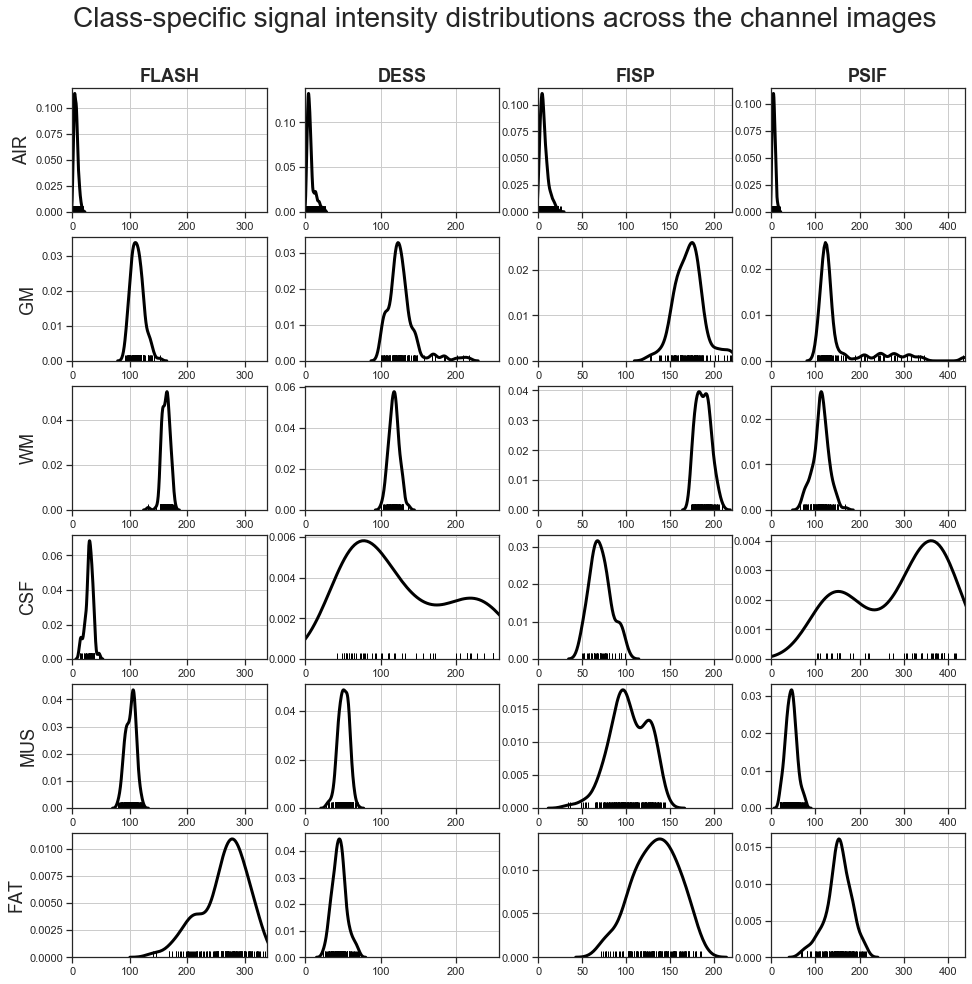

In [58]:
%matplotlib inline
# Make the 6 x 4 panels in the figure
fig, axes = plt.subplots(6, 4, figsize=(16, 16), sharex=False, sharey=False)
fig.suptitle("Class-specific signal intensity distributions across the channel images", 
             fontsize=28, y=0.95)   # y location of the text in figure coordinates

for k, cla in enumerate(class_names):
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FLASH.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,0])
    axes[k,0].set_xlim(mn1,mx1); axes[k,0].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].DESS.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,1])
    axes[k,1].set_xlim(mn2,mx2); axes[k,1].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].FISP.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,2])
    axes[k,2].set_xlim(mn3,mx3); axes[k,2].grid(True)
    sns.distplot(dfT.loc[dfT['Class']==cla.upper()].PSIF.values,
                 color="black", kde=True, rug=True, hist=False, kde_kws={"lw": 3},
                 ax=axes[k,3])
    axes[k,3].set_xlim(mn4,mx4); axes[k,3].grid(True)

# Make proper labels for the channel columns
for ch, chn in enumerate(chn_names):
    axes[0,ch].set_title(chn.upper(), fontsize=18, fontweight="bold")

# Make proper labels for the tissue type row-names
for k, cla in enumerate(class_names):
    axes[k,0].set(ylabel= cla.upper())
    axes[k,0].yaxis.label.set_size(18)

plt.show()

#fig.savefig('%s/prj/ELMED219/results/class_specific_si_densities_across_channels.pdf' % (home))

#fig.savefig('%s/prj/ELMED219/results/class_specific_si_densities_across_channels.png' % (home),
#           transparent=False, dpi=300, bbox_inches="tight")

**Lag et interaktivt 3D scatterplot (virker ikke med jupyter lab)**

Definer kombinasjoner av klasser og kanaler som kan brukes

In [59]:
x1air = list(dfT.loc[dfT['Class']=='AIR'].FLASH.values)
x2air = list(dfT.loc[dfT['Class']=='AIR'].DESS.values)
x3air = list(dfT.loc[dfT['Class']=='AIR'].FISP.values)

x1gm = list(dfT.loc[dfT['Class']=='GM'].FLASH.values)
x2gm = list(dfT.loc[dfT['Class']=='GM'].DESS.values)
x3gm = list(dfT.loc[dfT['Class']=='GM'].FISP.values)

x1wm = list(dfT.loc[dfT['Class']=='WM'].FLASH.values)
x2wm = list(dfT.loc[dfT['Class']=='WM'].DESS.values)
x3wm = list(dfT.loc[dfT['Class']=='WM'].FISP.values)

x1csf = list(dfT.loc[dfT['Class']=='CSF'].FLASH.values)
x2csf = list(dfT.loc[dfT['Class']=='CSF'].DESS.values)
x3csf = list(dfT.loc[dfT['Class']=='CSF'].FISP.values)

x1mus = list(dfT.loc[dfT['Class']=='MUS'].FLASH.values)
x2mus = list(dfT.loc[dfT['Class']=='MUS'].DESS.values)
x3mus = list(dfT.loc[dfT['Class']=='MUS'].FISP.values)

x1fat = list(dfT.loc[dfT['Class']=='FAT'].FLASH.values)
x2fat = list(dfT.loc[dfT['Class']=='FAT'].DESS.values)
x3fat = list(dfT.loc[dfT['Class']=='FAT'].FISP.values)

Lager 3D scatterplot (som ikke kan være interaktivt i jupyter lab)

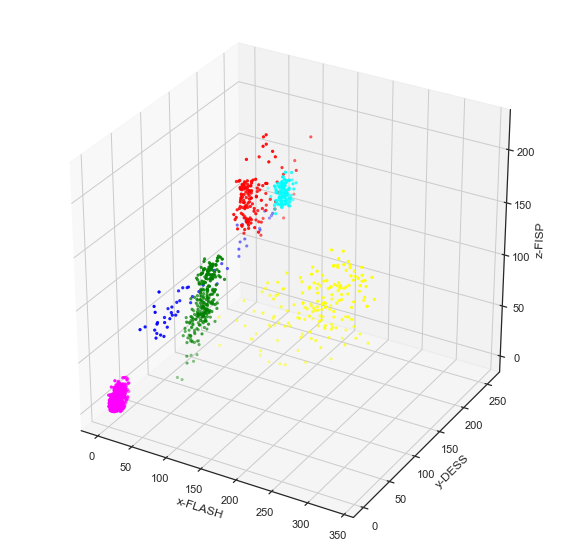

In [60]:
# Enables interactive 3D plot
# %matplotlib notebook 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# AIR = [255,0,255] # Magenta 
# GM  = [255,0,0]   # Red 
# WM  = [0,255,255] # Cyan 
# CSF = [0,0,255]   # Blue 
# MUS = [0,255,0]   # Green 
# FAT = [255,255,0] # Yellow 


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1air, x2air, x3air, c='magenta', marker='.')
ax.scatter(x1gm, x2gm, x3gm, c='red', marker='.')
ax.scatter(x1wm, x2wm, x3wm, c='cyan', marker='.')
ax.scatter(x1csf, x2csf, x3csf, c='blue', marker='.')
ax.scatter(x1mus, x2mus, x3mus, c='green', marker='.')
ax.scatter(x1fat, x2fat, x3fat, c='yellow', marker='.')

ax.set_xlabel('x-FLASH')
ax.set_ylabel('y-DESS')
ax.set_zlabel('z-FISP')

plt.show()

## Kontrast-til-støy (CNR) i MR bilder

 - **På bakgrunn av de klasse-vise signal-intensitet fordelinger for hver av kanalene (vist i figur over), diskuter:** 

    1.  Hvilken kanal er best til å skille mellom GM og WM? 

    2.  Er det lett å skille mellom `grå substans` og `muskel` i FLASH-sekvensen?

    3.  Hvorfor viser  signal-intensitet til CSF så stor variasjon i den T2-vektede kanalen DESS? <br> 
  (hint: https://www.ajronline.org/doi/10.2214/AJR.05.0003)

 - **Skriv ned dine resultater (grafer, tabeller, bilder) til en lokal katalog på din maskin** <br>
 
   (hint: lag en katalog utenfor Git-repositoriet , e.g. $HOME/prj/ELMED219/results, og legg til
   følgende setning i cellen over som viser vevs-spesifikke SI-fordelinger (sannsynlighets-tettheter) for hver av kanalene: 
   
   ```python
   import os
   home = os.path.expanduser('~')
   
   fig.savefig('%s/prj/ELMED219/results/class_specific_si_densities_across_channels.png' % (home), transparent=False, dpi=80, bbox_inches="tight")
   ```

   Videre, lagre også tidligere celle-figurer som illustrer data og resultater i samme katalog, i.e.
   
   ```python
   fig.savefig('%s/prj/ELMED219/results/flash_dess_fisp_psif_channel_images.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ```
   og
   ```python
   fig.savefig('%s/prj/ELMED219/results/flash_with_training_mask_6_classes.png' % (home),
   transparent=False, dpi=300, bbox_inches="tight")
   ```   

- **Lag en kontrast-til-støy-forhold (CNR) tabell (data frame) mellom hvert par av vevsklasser for hver av kanalene** <br>

     - Hint: Vi definerer CNR mellom vevstype GM og vevstype WM i kanal FLASH ved: 
  
> CNR(GM,WM)$_{FLASH}$  =  abs(mean(GM)$_{FLASH}$ - mean(WM)$_{FLASH}$) / std(AIR)$_{FLASH}$

- Hint for beregning av støy i sekvensen av kanaler:

```python
D = pd.read_csv('../testdata/multispectral_mri_training_data.csv')

sigma_0 = np.zeros(len(chn_names))
for k, chn in enumerate(chn_names):
    sigma_0[k] = np.std(list(D.loc[D['Class']=='AIR'][chn].values)).round(3)

list(sigma_0)
```

- Hint for beregning av CNR(vev_a, vev_b, kanal_chn) som funksjon: 

```python
def cnr(a,b,chn):
    s_0 = np.std(list(D.loc[D['Class']=='AIR'][chn].values))
    mu_a = np.mean(list(D.loc[D['Class']==a][chn].values))
    mu_b = np.mean(list(D.loc[D['Class']==b][chn].values))
    cnr_a_b = abs(mu_a - mu_b)/ s_0
    return cnr_a_b

cnr('AIR','GM','FLASH').round(2)
```

    - Fyll inn i tabellen (eller  i tilsvarende format):

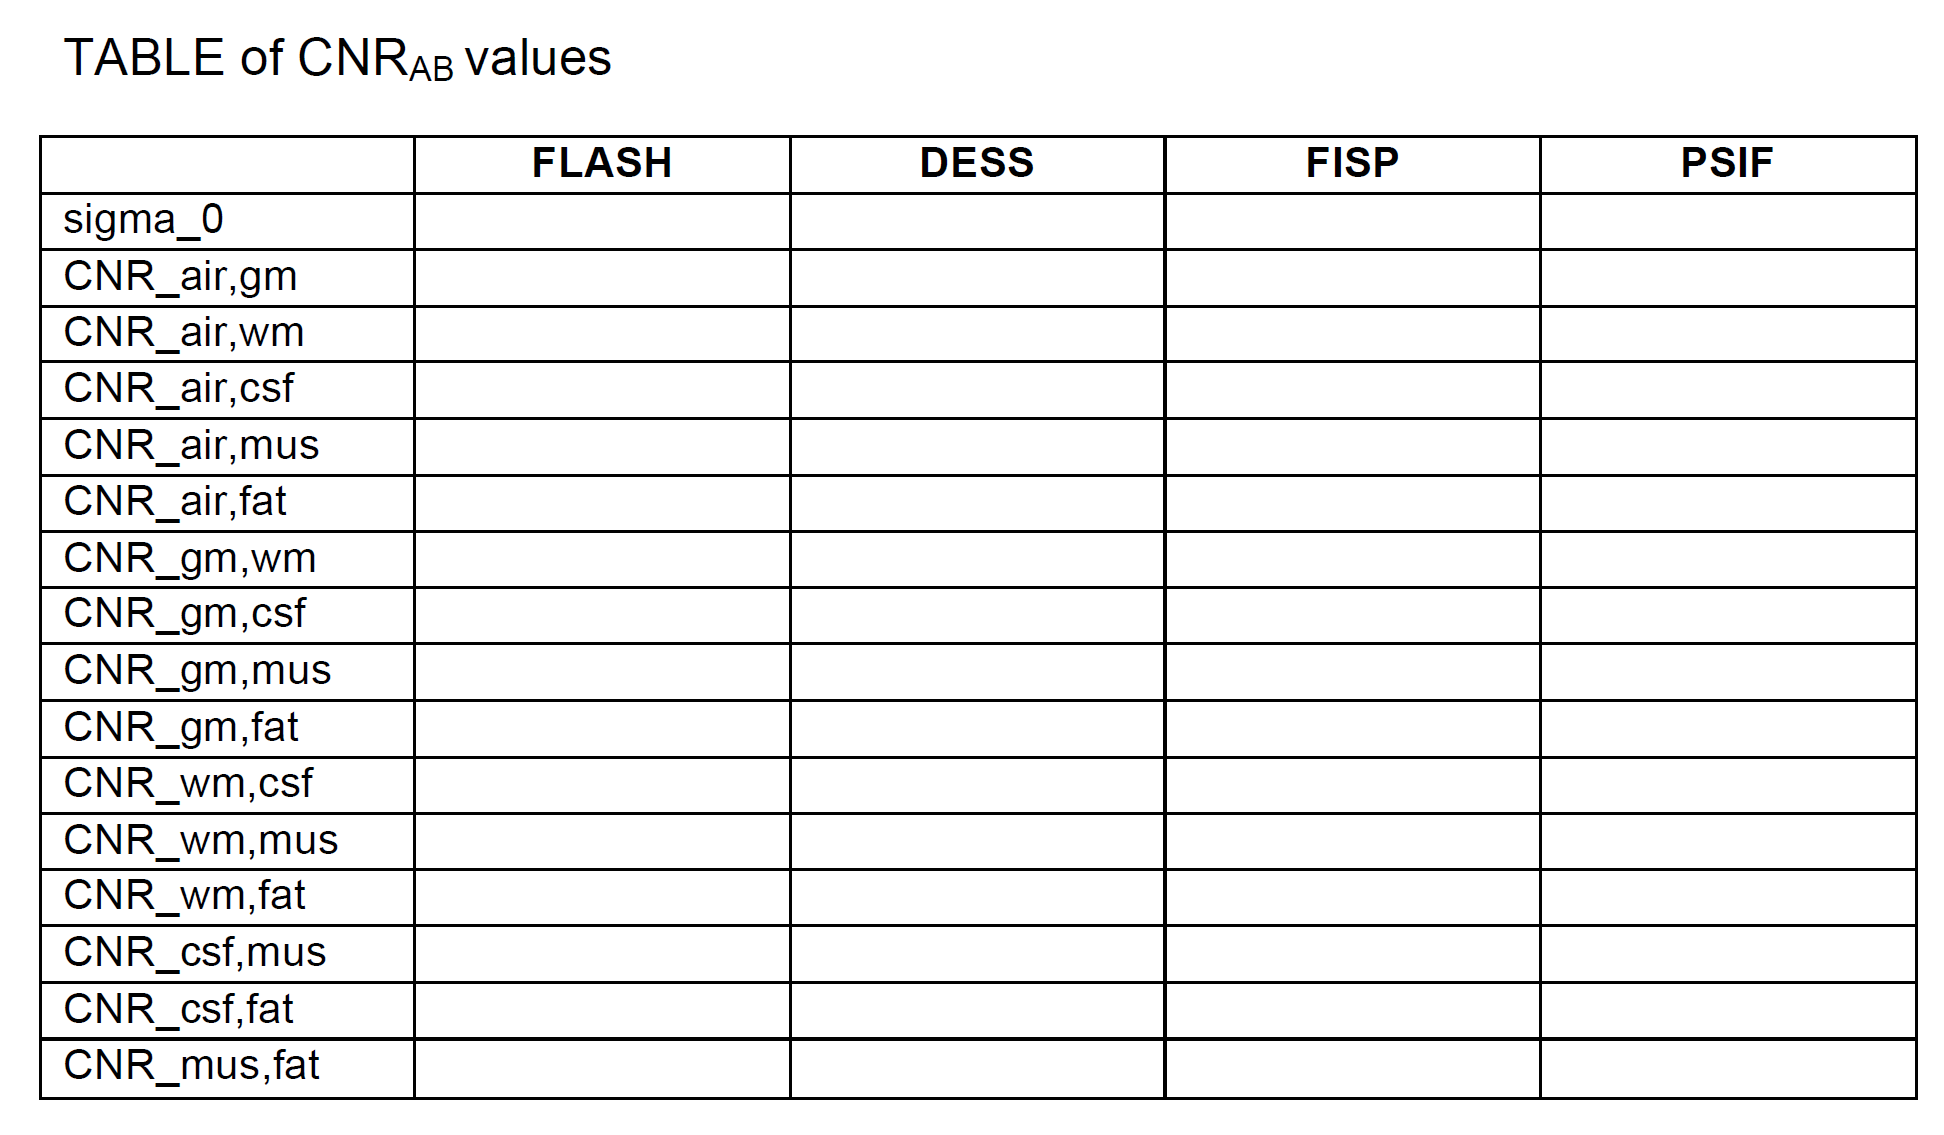

In [61]:
from IPython.display import Image
Image(filename='./assets/multispectral_mri_cnr_table.png', width=600)

- For hvilke par av vevsklasser og i hvilken kanal finner vi det høyeste kontrast-til-støy-forhold?


- Hvilken kanal har det minste støy-nivå (slik vi har definert det i innledningen)? 

_(Hjerne-masken (ROI mask) har ikke blitt aktivt benyttet, men vil komme i bruk i neste del som omfatter  **vevsklassifikasjon** med maskinlæringsmetoder)_